# section 3.1 (part A): 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from tqdm import tqdm
import os
import random
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ==========================================================================================
# STEP 1: CONFIGURATION
# All settings are here to make the script easy to modify and reproduce.
# ==========================================================================================
CONFIG_3_1  = {
    # "dataset_path": "/kaggle/input/pacs-dataset/pacs_data",  # Path to the parent directory of the dataset
    "dataset_path": "D:\Salaar Masood\pacs-dataset\pacs_data",  # Path to the parent directory of the dataset
    "domains": ["art_painting", "cartoon", "photo", "sketch"],
    "class_names": ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"], # From PACS
    "model_name": "openai/clip-vit-base-patch32",  # A standard CLIP model
    "batch_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
    "prompt_strategies": {
        "generic": "a photo of a {}.",
        "domain_specific": {
            "art_painting": "an artwork of a {}.",
            "cartoon": "a cartoon of a {}.",
            "photo": "a photo of a {}.",
            "sketch": "a sketch of a {}.",
        }
    },
    "selected_strategy": "generic",
    "linear_probe": {
        "pairs_to_run": [
            {"source": "photo", "target": "sketch"},
            {"source": "photo", "target": "art_painting"},
            {"source": "art_painting", "target": "sketch"},
        ],
        "train_split_ratio": 0.8, # 80% for training, 20% for source validation
        "num_epochs": 10,
        "learning_rate": 1e-3,
        "feature_dim": 512, # From clip-vit-base-patch32
        "num_classes": 7,   # For PACS dataset
    },
    "dapl_prompt": {
        "pairs_to_run": [
            {"source": "photo", "target": "sketch"},
            {"source": "photo", "target": "art_painting"},
            {"source": "art_painting", "target": "sketch"},
        ],
        "num_epochs": 10,
        "learning_rate": 2e-4, # A smaller LR is good for fine-tuning prompts
        # Hyperparameters adapted from the DAPL paper
        "n_ctx": 16,  # Number of domain-agnostic context vectors
        "n_dmx": 16,  # Number of domain-specific context vectors
        "T": 1.0,     # Temperature for sharpening pseudo-label distribution
        "TAU": 0.7,   # Confidence threshold for pseudo-labels
        "U": 1.0,     # Weight for the unsupervised loss
    }
}

In [7]:
def set_seed(seed):
    """
    Sets the random seed for reproducibility across different libraries.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # The following two lines are often recommended for Torch reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(CONFIG_3_1 ["seed"])
print(f"Random seed set to: {CONFIG_3_1 ['seed']}")

Random seed set to: 42


In [8]:
# ==========================================================================================
# STEP 2: DATA LOADING FUNCTION
# This function creates a DataLoader for a specific domain's test set.
# ==========================================================================================
def get_dataloader(domain_name, transform, batch_size, dataset_path):
    """
    Creates a DataLoader for the test set of a specified domain.
    Args:
        domain_name (str): The name of the domain (e.g., 'art_painting').
        transform: The image transformation pipeline from the CLIP processor.
        batch_size (int): The number of samples per batch.
        dataset_path (str): The root path of the dataset.
    Returns:
        A tuple of (DataLoader, list of class names).
    """
    domain_path = os.path.join(dataset_path, domain_name)
    if not os.path.exists(domain_path):
        raise FileNotFoundError(f"Domain folder not found at: {domain_path}")
        
    # ImageFolder automatically finds classes from folder names
    dataset = ImageFolder(root=domain_path, transform=transform)
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False, # No need to shuffle for evaluation
        num_workers=0, # 4 before for kaggle
        pin_memory=True,
    )
    
    return loader, dataset.classes

In [9]:
# ==========================================================================================
# STEP 3: MAIN EVALUATION SCRIPT
# ==========================================================================================
def main():
    print(f"Starting zero-shot evaluation on {CONFIG_3_1 ['device']}...")
    print(f"Using prompt strategy: '{CONFIG_3_1 ['selected_strategy']}'")

    model = CLIPModel.from_pretrained(CONFIG_3_1 ["model_name"]).to(CONFIG_3_1 ["device"])
    processor = CLIPProcessor.from_pretrained(CONFIG_3_1 ["model_name"])
    image_transform = lambda img: processor.image_processor(
        img, return_tensors="pt"
    )['pixel_values'].squeeze(0)

    results = {}

    _, class_names = get_dataloader(CONFIG_3_1 ["domains"][0], image_transform, CONFIG_3_1 ["batch_size"], CONFIG_3_1 ["dataset_path"])
    print(f"Found {len(class_names)} classes.")

    # --- Evaluation Loop ---
    for domain in CONFIG_3_1 ["domains"]:
        print(f"\nEvaluating domain: {domain}...")

        # <<< MODIFICATION: Select the correct prompt template based on the strategy
        strategy_config = CONFIG_3_1 ["prompt_strategies"][CONFIG_3_1 ["selected_strategy"]]
        if isinstance(strategy_config, dict):
            # Domain-specific strategy
            prompt_template = strategy_config[domain]
        else:
            # Generic strategy
            prompt_template = strategy_config
        
        print(f"Using prompt: '{prompt_template}'")
        
        # <<< MODIFICATION: Prepare text prompts inside the loop
        text_prompts = [prompt_template.format(c) for c in class_names]
        text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(CONFIG_3_1 ["device"])

        try:
            test_loader, _ = get_dataloader(domain, image_transform, CONFIG_3_1 ["batch_size"], CONFIG_3_1 ["dataset_path"])
        except FileNotFoundError as e:
            print(e); continue

        total_correct = 0
        total_samples = 0
        
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Testing {domain}"):
                images, labels = images.to(CONFIG_3_1 ["device"]), labels.to(CONFIG_3_1 ["device"])
                
                outputs = model(pixel_values=images, input_ids=text_inputs.input_ids, attention_mask=text_inputs.attention_mask)
                logits_per_image = outputs.logits_per_image
                predictions = torch.argmax(logits_per_image, dim=1)
                
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
    
        accuracy = (total_correct / total_samples) * 100
        results[domain] = accuracy
        print(f"Accuracy on {domain}: {accuracy:.2f}%")

    # --- Print Final Summary Table ---
    print("\n" + "="*50)
    print(f"  Summary for '{CONFIG_3_1 ['selected_strategy']}' Prompt Strategy  ")
    print("="*50)
    print(f"{'Domain':<20} | {'Accuracy (%)':<15}")
    print("-"*50)
    for domain, acc in results.items():
        print(f"{domain:<20} | {acc:<15.2f}")
    print("="*50)

if __name__ == "__main__":
    main()

Starting zero-shot evaluation on cuda...
Using prompt strategy: 'generic'


C:\Users\Fatim_Sproj\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Fatim_Sproj\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fal

Found 7 classes.

Evaluating domain: art_painting...
Using prompt: 'a photo of a {}.'


Testing art_painting: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


Accuracy on art_painting: 96.29%

Evaluating domain: cartoon...
Using prompt: 'a photo of a {}.'


Testing cartoon: 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Accuracy on cartoon: 98.17%

Evaluating domain: photo...
Using prompt: 'a photo of a {}.'


Testing photo: 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Accuracy on photo: 99.82%

Evaluating domain: sketch...
Using prompt: 'a photo of a {}.'


Testing sketch: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s]

Accuracy on sketch: 85.19%

  Summary for 'generic' Prompt Strategy  
Domain               | Accuracy (%)   
--------------------------------------------------
art_painting         | 96.29          
cartoon              | 98.17          
photo                | 99.82          
sketch               | 85.19          


# section 3.1 (part B): 

In [ ]:
# Cell 2: Data Preparation (Quick Fix for Windows)
def get_dataloaders_for_probing(domain_name, transform, batch_size, dataset_path, train_split_ratio):
    domain_path = os.path.join(dataset_path, domain_name)
    full_dataset = ImageFolder(root=domain_path, transform=transform)
    
    num_train = int(len(full_dataset) * train_split_ratio)
    num_val = len(full_dataset) - num_train
    
    # Assuming CONFIG_3_1.seed is defined
    generator = torch.Generator().manual_seed(CONFIG_3_1["seed"])
    train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val], generator=generator)
    
    # <<< FIX: Set num_workers=0 to avoid pickling error on Windows >>>
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader

def get_test_dataloader(domain_name, transform, batch_size, dataset_path):
    domain_path = os.path.join(dataset_path, domain_name)
    test_dataset = ImageFolder(root=domain_path, transform=transform)
    
    # <<< FIX: Set num_workers=0 to avoid pickling error on Windows >>>
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return test_loader

print("Data preparation functions (with num_workers=0 fix) defined.")

Data preparation functions (with num_workers=0 fix) defined.


In [14]:
def extract_features(clip_model, data_loader, device):
    """
    Pre-computes and saves CLIP image features and labels for a given dataset.
    """
    features = []
    labels = []
    
    clip_model.eval()
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device)
            # We only need the image features, not the text features or logits
            image_features = clip_model.get_image_features(pixel_values=images)
            features.append(image_features.cpu())
            labels.append(lbls.cpu())
            
    # Concatenate all features and labels into single tensors
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return TensorDataset(features, labels)

print("Feature extraction function defined.")

Feature extraction function defined.


In [15]:
# 1. DEFINE THE LINEAR PROBE MODEL
class LinearProbe(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LinearProbe, self).__init__()
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.classifier(x)
        
# 2. MAIN SCRIPT
def main_linear_probe():
    # --- Load Frozen CLIP Model ---
    print("Loading CLIP model for feature extraction...")
    device = CONFIG_3_1 ["device"]
    clip_model = CLIPModel.from_pretrained(CONFIG_3_1 ["model_name"]).to(device)
    processor = CLIPProcessor.from_pretrained(CONFIG_3_1 ["model_name"])
    image_transform = lambda img: processor.image_processor(img, return_tensors="pt")['pixel_values'].squeeze(0)
    
    probe_config = CONFIG_3_1 ["linear_probe"]
    results = []

    # --- Loop over experimental pairs ---
    for pair in probe_config["pairs_to_run"]:
        source_domain = pair["source"]
        target_domain = pair["target"]
        print("\n" + "="*50)
        print(f"Running Experiment: Source='{source_domain}' -> Target='{target_domain}'")
        print("="*50)

        # --- a. Data Preparation ---
        print("1. Preparing data loaders...")
        source_train_loader, source_val_loader = get_dataloaders_for_probing(
            source_domain, image_transform, CONFIG_3_1 ["batch_size"], CONFIG_3_1 ["dataset_path"], probe_config["train_split_ratio"]
        )
        target_loader = get_test_dataloader(target_domain, image_transform, CONFIG_3_1 ["batch_size"], CONFIG_3_1 ["dataset_path"])

        # --- b. Feature Extraction ---
        print("2. Extracting features (this may take a moment)...")
        source_train_features = extract_features(clip_model, source_train_loader, device)
        source_val_features = extract_features(clip_model, source_val_loader, device)
        target_features = extract_features(clip_model, target_loader, device)
        
        # Create DataLoaders from the pre-computed features
        train_feature_loader = DataLoader(source_train_features, batch_size=CONFIG_3_1 ["batch_size"], shuffle=True)
        val_feature_loader = DataLoader(source_val_features, batch_size=CONFIG_3_1 ["batch_size"])
        target_feature_loader = DataLoader(target_features, batch_size=CONFIG_3_1 ["batch_size"])

        # --- c. Model Training ---
        print("3. Training the linear probe...")
        probe_model = LinearProbe(probe_config["feature_dim"], probe_config["num_classes"]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(probe_model.parameters(), lr=probe_config["learning_rate"])

        for epoch in range(probe_config["num_epochs"]):
            probe_model.train()
            for features, labels in train_feature_loader:
                features, labels = features.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = probe_model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            # print(f"Epoch [{epoch+1}/{probe_config['num_epochs']}], Loss: {loss.item():.4f}") # Optional per-epoch loss

        # --- d. Evaluation ---
        print("4. Evaluating the trained probe...")
        probe_model.eval()
        
        # Evaluate on Source Domain
        correct, total = 0, 0
        with torch.no_grad():
            for features, labels in val_feature_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = probe_model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        source_accuracy = 100 * correct / total
        
        # Evaluate on Target Domain
        correct, total = 0, 0
        with torch.no_grad():
            for features, labels in target_feature_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = probe_model(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        target_accuracy = 100 * correct / total
        
        print(f"Source Accuracy ({source_domain}): {source_accuracy:.2f}%")
        print(f"Target Accuracy ({target_domain}): {target_accuracy:.2f}%")
        
        results.append({
            "source": source_domain,
            "target": target_domain,
            "source_acc": source_accuracy,
            "target_acc": target_accuracy,
        })

    # --- 3. Print Final Summary Table ---
    print("\n" + "="*60)
    print("         Summary of Linear Probe Performance         ")
    print("="*60)
    print(f"{'Source':<15} | {'Target':<15} | {'Source Acc (%)':<15} | {'Target Acc (%)':<15}")
    print("-"*60)
    for res in results:
        print(f"{res['source']:<15} | {res['target']:<15} | {res['source_acc']:<15.2f} | {res['target_acc']:<15.2f}")
    print("="*60)

# Run the entire process
main_linear_probe()

Loading CLIP model for feature extraction...

Running Experiment: Source='photo' -> Target='sketch'
1. Preparing data loaders...
2. Extracting features (this may take a moment)...


Extracting features: 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]


3. Training the linear probe...
4. Evaluating the trained probe...
Source Accuracy (photo): 99.40%
Target Accuracy (sketch): 84.58%

Running Experiment: Source='photo' -> Target='art_painting'
1. Preparing data loaders...
2. Extracting features (this may take a moment)...


Extracting features: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


3. Training the linear probe...
4. Evaluating the trained probe...
Source Accuracy (photo): 99.40%
Target Accuracy (art_painting): 78.96%

Running Experiment: Source='art_painting' -> Target='sketch'
1. Preparing data loaders...
2. Extracting features (this may take a moment)...


Extracting features: 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

3. Training the linear probe...
4. Evaluating the trained probe...
Source Accuracy (art_painting): 96.10%
Target Accuracy (sketch): 87.68%

         Summary of Linear Probe Performance         
Source          | Target          | Source Acc (%)  | Target Acc (%) 
------------------------------------------------------------
photo           | sketch          | 99.40           | 84.58          
photo           | art_painting    | 99.40           | 78.96          
art_painting    | sketch          | 96.10           | 87.68          


# section 3.2:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel
from torch.nn import functional as F
from tqdm import tqdm
import os
import random
import numpy as np
from clip import clip
from torch.cuda.amp import GradScaler, autocast


# --- Environment Setup (can be repeated for clarity) ---
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # For debugging

# --- Seeding Function (can be repeated for clarity) ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Main Configuration for Task 3.2 ---
CONFIG_3_2 = {
    # "dataset_path": "/kaggle/input/pacs-dataset/pacs_data",
    "dataset_path": "D:\Salaar Masood\pacs-dataset\pacs_data",  # Path to the parent directory of the dataset
    "domains": ["art_painting", "cartoon", "photo", "sketch"],
    "class_names": ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"],
    # CRITICAL: Use the model name compatible with the 'clip' library
    "model_name": "ViT-B/32",
    "batch_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,

    # --- Config specifically for DAPrompt ---
    "dapl_prompt": {
        "pairs_to_run": [
            {"source": "photo", "target": "sketch"},
            {"source": "photo", "target": "art_painting"},
            {"source": "art_painting", "target": "sketch"},
        ],
        "num_epochs": 10,
        "learning_rate": 1e-4,
        "n_ctx": 16,  # Domain-agnostic vectors
        "n_dmx": 16,  # Domain-specific vectors
        "T": 1.0,     # Temperature for pseudo-labels
        "TAU": 0.7,   # Confidence threshold
        "U": 1.0,     # Unsupervised loss weight
    }
}

# Set the seed for reproducibility
set_seed(CONFIG_3_2["seed"])
print(f"Configuration for Task 3.2 loaded. Random seed set to: {CONFIG_3_2['seed']}")

C:\Users\Fatim_Sproj\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration for Task 3.2 loaded. Random seed set to: 42


In [5]:
# The Final, Unified, and Correct DAPrompt and TextEncoder Classes

class TextEncoder(nn.Module):
    def __init__(self, clip_model, dtype):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        # The data type is passed in during initialization
        self.dtype = dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2); x = self.transformer(x); x = x.permute(1, 0, 2)
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x

class DAPrompt(nn.Module):
    def __init__(self, cfg, class_names, clip_model, precision="amp"):
        """
        Initializes the DAPrompt model.
        Args:
            cfg: The configuration dictionary.
            class_names: A list of class names.
            clip_model: The pre-trained CLIP model.
            precision (str): The computation precision. Must be 'amp' (for mixed-precision)
                             or 'fp32' (for full precision).
        """
        super().__init__()
        if precision not in ["amp", "fp32"]:
            raise ValueError("Precision must be either 'amp' or 'fp32'")

        # 1. Set the working data type based on the precision mode
        if precision == "amp":
            self.dtype = clip_model.dtype  # Use the model's native dtype (e.g., float16)
        else: # precision == "fp32"
            self.dtype = torch.float32 # Force float32 for diagnostics

        self.n_classes = len(class_names)
        
        dapl_cfg = cfg['dapl_prompt']
        n_ctx, n_dmx = dapl_cfg['n_ctx'], dapl_cfg['n_dmx']
        ctx_dim = clip_model.ln_final.weight.shape[0]

        # Learnable parameters are ALWAYS kept in FP32
        self.ctx = nn.Parameter(torch.empty(n_ctx, ctx_dim, dtype=torch.float32))
        self.domain_vectors = nn.Parameter(torch.empty(len(cfg['domains']), n_dmx, ctx_dim, dtype=torch.float32))
        nn.init.normal_(self.ctx, std=0.02); nn.init.normal_(self.domain_vectors, std=0.02)
        
        self.domain_map = {name: i for i, name in enumerate(cfg['domains'])}

        # 2. Instantiate the TextEncoder with the correct dtype
        self.text_encoder = TextEncoder(clip_model, self.dtype)
        
        self.image_encoder = clip_model.visual
        self.logit_scale = clip_model.logit_scale
        self.token_embedding = clip_model.token_embedding
        
        prompt_prefix = " ".join(["X"] * (n_ctx + n_dmx))
        prompts = [prompt_prefix + " " + name.replace("_", " ") + "." for name in class_names]
        
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(cfg['device'])
        self.register_buffer("tokenized_prompts", tokenized_prompts)
        with torch.no_grad():
            embedding = self.token_embedding(self.tokenized_prompts).type(self.dtype)
        
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + (n_ctx + n_dmx):, :])

    def forward(self, image, domain_name):
        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        domain_idx = self.domain_map[domain_name]
        learnable_prompt_vectors = torch.cat([self.ctx, self.domain_vectors[domain_idx]], dim=0)
        
        prompts = learnable_prompt_vectors.unsqueeze(0).expand(self.n_classes, -1, -1)
        
        # This explicit cast is the key fix that makes both modes work
        prompts = prompts.to(self.dtype)
        
        final_embedding = torch.cat([self.token_prefix, prompts, self.token_suffix], dim=1)

        text_features = self.text_encoder(final_embedding, self.tokenized_prompts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logits = self.logit_scale.exp() * image_features @ text_features.t()
        return logits

In [7]:
def get_source_target_loaders(source_domain, target_domain, transform, batch_size, dataset_path):
    """Creates separate DataLoaders for the source and target domains."""
    source_path = os.path.join(dataset_path, source_domain)
    target_path = os.path.join(dataset_path, target_domain)
    
    source_dataset = ImageFolder(root=source_path, transform=transform)
    target_dataset = ImageFolder(root=target_path, transform=transform)
    
    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
    
    # We also need a test loader for the target domain for final evaluation
    test_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return source_loader, target_loader, test_loader

print("Data loading function defined.")

Data loading function defined.


In [29]:
# The main function for Task 3.2, now using the reliable FP32 mode.

def main_dapl():
    # --- Load Frozen CLIP Model and its matched Preprocessor ---
    print("Loading CLIP model...")
    device = CONFIG_3_2["device"]
    
    # <<< FIX: Load model and CONVERT TO FP32
    clip_model, image_transform = clip.load(CONFIG_3_2["model_name"], device=device)
    clip_model.float()
    
    dapl_config = CONFIG_3_2["dapl_prompt"]
    results = []

    # --- Loop over experimental pairs ---
    for pair in dapl_config["pairs_to_run"]:
        source_domain = pair["source"]
        target_domain = pair["target"]
        print("\n" + "="*50)
        print(f"Running Experiment (FP32 Mode): Source='{source_domain}' -> Target='{target_domain}'")
        print("="*50)

        # --- a. Data Preparation ---
        print("1. Preparing data loaders...")
        source_loader, target_loader, test_loader = get_source_target_loaders(
            source_domain, target_domain, image_transform, CONFIG_3_2["batch_size"], CONFIG_3_2["dataset_path"]
        )

        # --- b. Model and Optimizer Setup ---
        print("2. Setting up DAPrompt model and optimizer...")
        # <<< FIX: Instantiate the model in 'fp32' mode
        model = DAPrompt(CONFIG_3_2, CONFIG_3_2["class_names"], clip_model, precision="fp32").to(device)
        
        # Freezing logic remains the same
        for name, param in model.named_parameters():
            if "ctx" not in name and "domain_vectors" not in name:
                param.requires_grad_(False)
        
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(trainable_params, lr=dapl_config["learning_rate"])
        criterion = nn.CrossEntropyLoss()
        
        # <<< FIX: GradScaler is REMOVED

        # --- c. Training Loop ---
        print("3. Starting training...")
        num_batches = min(len(source_loader), len(target_loader))
        
        for epoch in range(dapl_config["num_epochs"]):
            model.train()
            source_iter = iter(source_loader)
            target_iter = iter(target_loader)
            
            total_loss, total_loss_x, total_loss_u = 0, 0, 0
            
            for step in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{dapl_config['num_epochs']}"):
                source_images, source_labels = next(source_iter)
                target_images, _ = next(target_iter)
                source_images, source_labels = source_images.to(device), source_labels.to(device)
                target_images = target_images.to(device)
                
                optimizer.zero_grad()
                
                # <<< FIX: 'autocast' is REMOVED
                source_logits = model(source_images, domain_name=source_domain)
                target_logits = model(target_images, domain_name=target_domain)
                loss_x = criterion(source_logits, source_labels)
                with torch.no_grad():
                    target_probs = torch.softmax(target_logits / dapl_config["T"], dim=-1)
                    max_probs, pseudo_labels = torch.max(target_probs, dim=-1)
                    mask = (max_probs >= dapl_config["TAU"]).float()
                unmasked_loss_u = F.cross_entropy(target_logits, pseudo_labels, reduction="none")
                loss_u = (unmasked_loss_u * mask).sum() / (mask.sum() + 1e-6)
                loss = loss_x + dapl_config["U"] * loss_u
                
                # <<< FIX: Standard backward pass, no scaler
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                total_loss_x += loss_x.item()
                if mask.sum() > 0:
                    total_loss_u += loss_u.item()

            avg_loss = total_loss / num_batches
            print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f} (Source: {total_loss_x/num_batches:.4f}, Target: {total_loss_u/num_batches:.4f})")

        # --- d. Evaluation ---
        print("4. Evaluating on target domain...")
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Evaluating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, domain_name=target_domain)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        target_accuracy = 100 * correct / total
        print(f"Final Target Accuracy ({target_domain}): {target_accuracy:.2f}%")
        
        results.append({ "source": source_domain, "target": target_domain, "target_acc": target_accuracy })

    # --- Print Final Summary Table ---
    # ... (this part is unchanged)

# Run the entire process
main_dapl()

Loading CLIP model...

Running Experiment (FP32 Mode): Source='photo' -> Target='sketch'
1. Preparing data loaders...
2. Setting up DAPrompt model and optimizer...
3. Starting training...


Epoch 1/10: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch 1 Avg Loss: 0.4298 (Source: 0.3503, Target: 0.0795)


Epoch 2/10: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 2 Avg Loss: 0.0930 (Source: 0.0393, Target: 0.0537)


Epoch 3/10: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 3 Avg Loss: 0.0516 (Source: 0.0142, Target: 0.0374)


Epoch 4/10: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch 4 Avg Loss: 0.0403 (Source: 0.0102, Target: 0.0301)


Epoch 5/10: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 5 Avg Loss: 0.0354 (Source: 0.0085, Target: 0.0269)


Epoch 6/10: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 6 Avg Loss: 0.0305 (Source: 0.0075, Target: 0.0231)


Epoch 7/10: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 7 Avg Loss: 0.0299 (Source: 0.0064, Target: 0.0235)


Epoch 8/10: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch 8 Avg Loss: 0.0322 (Source: 0.0064, Target: 0.0259)


Epoch 9/10: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch 9 Avg Loss: 0.0263 (Source: 0.0058, Target: 0.0205)


Epoch 10/10: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 10 Avg Loss: 0.0272 (Source: 0.0052, Target: 0.0220)
4. Evaluating on target domain...


Evaluating: 100%|██████████| 31/31 [00:08<00:00,  3.66it/s]


Final Target Accuracy (sketch): 90.23%

Running Experiment (FP32 Mode): Source='photo' -> Target='art_painting'
1. Preparing data loaders...
2. Setting up DAPrompt model and optimizer...
3. Starting training...


Epoch 1/10: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 1 Avg Loss: 0.4208 (Source: 0.2777, Target: 0.1432)


Epoch 2/10: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 2 Avg Loss: 0.0998 (Source: 0.0365, Target: 0.0634)


Epoch 3/10: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch 3 Avg Loss: 0.0709 (Source: 0.0213, Target: 0.0495)


Epoch 4/10: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 4 Avg Loss: 0.0517 (Source: 0.0160, Target: 0.0357)


Epoch 5/10: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 5 Avg Loss: 0.0416 (Source: 0.0132, Target: 0.0284)


Epoch 6/10: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 6 Avg Loss: 0.0368 (Source: 0.0117, Target: 0.0251)


Epoch 7/10: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 7 Avg Loss: 0.0317 (Source: 0.0101, Target: 0.0216)


Epoch 8/10: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch 8 Avg Loss: 0.0302 (Source: 0.0094, Target: 0.0208)


Epoch 9/10: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch 9 Avg Loss: 0.0278 (Source: 0.0087, Target: 0.0191)


Epoch 10/10: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch 10 Avg Loss: 0.0265 (Source: 0.0080, Target: 0.0185)
4. Evaluating on target domain...


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Final Target Accuracy (art_painting): 96.78%

Running Experiment (FP32 Mode): Source='art_painting' -> Target='sketch'
1. Preparing data loaders...
2. Setting up DAPrompt model and optimizer...
3. Starting training...


Epoch 1/10: 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


Epoch 1 Avg Loss: 0.7513 (Source: 0.6168, Target: 0.1345)


Epoch 2/10: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Epoch 2 Avg Loss: 0.2013 (Source: 0.1557, Target: 0.0456)


Epoch 3/10: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


Epoch 3 Avg Loss: 0.1407 (Source: 0.1079, Target: 0.0327)


Epoch 4/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch 4 Avg Loss: 0.1222 (Source: 0.0937, Target: 0.0285)


Epoch 5/10: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s]


Epoch 5 Avg Loss: 0.1128 (Source: 0.0861, Target: 0.0267)


Epoch 6/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch 6 Avg Loss: 0.1059 (Source: 0.0809, Target: 0.0250)


Epoch 7/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch 7 Avg Loss: 0.1014 (Source: 0.0766, Target: 0.0249)


Epoch 8/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch 8 Avg Loss: 0.0939 (Source: 0.0717, Target: 0.0222)


Epoch 9/10: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


Epoch 9 Avg Loss: 0.0906 (Source: 0.0687, Target: 0.0219)


Epoch 10/10: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Epoch 10 Avg Loss: 0.0859 (Source: 0.0645, Target: 0.0214)
4. Evaluating on target domain...


Evaluating: 100%|██████████| 31/31 [00:08<00:00,  3.65it/s]

Final Target Accuracy (sketch): 89.41%


# section 3.3:

In [4]:
CONFIG_3_3 = CONFIG_3_2.copy() # Start with a copy of the previous config

CONFIG_3_3["gradient_analysis"] = {
    # We'll analyze the most interesting pair from the previous task
    "pair_to_analyze": {"source": "photo", "target": "art_painting"},
    
    # Define at which steps within each epoch to measure similarity
    # Let's measure at the start, middle, and end of the data stream
    "measure_steps": [0, 2, 5, 8, 10, 12] 
}

# Assuming DAPrompt class, TextEncoder, and get_source_target_loaders are available from previous cells
print("Configuration for Task 3.3 loaded.")

Configuration for Task 3.3 loaded.


In [5]:
# Cell 2: Gradient Helper Function (New Version)

def retrieve_trainable_gradients(model):
    """
    Retrieves a list of gradient tensors from the model's trainable parameters.
    Inspired by the _retrieve_grad logic in pcgrad.py.
    """
    grad_list = []
    for param in model.parameters():
        # Only consider parameters that are being trained
        if param.requires_grad and param.grad is not None:
            # Clone the gradient to avoid it being modified by subsequent operations
            grad_list.append(param.grad.clone())
    return grad_list

print("New gradient helper function defined.")

New gradient helper function defined.


In [8]:
# Cell 2: Main Gradient Analysis Script (Full FP32 Precision Version)

def main_gradient_analysis():
    # --- Setup ---
    device = CONFIG_3_3["device"]
    # FIX: Load the model and convert the relevant parts to FP32 immediately
    clip_model, image_transform = clip.load(CONFIG_3_3["model_name"], device=device)
    clip_model.float()
    
    analysis_config = CONFIG_3_3["gradient_analysis"]
    dapl_config = CONFIG_3_3["dapl_prompt"]
    source_domain = analysis_config["pair_to_analyze"]["source"]
    target_domain = analysis_config["pair_to_analyze"]["target"]
    
    print("\n" + "="*50)
    print(f"Running Gradient Analysis (FP32): Source='{source_domain}' -> Target='{target_domain}'")
    print("="*50)

    # --- Data, Model, Optimizer ---
    source_loader, target_loader, _ = get_source_target_loaders(
        source_domain, target_domain, image_transform, CONFIG_3_3["batch_size"], CONFIG_3_3["dataset_path"]
    )
    model = DAPrompt(CONFIG_3_3, CONFIG_3_3["class_names"], clip_model, precision="fp32").to(device)
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=dapl_config["learning_rate"])
    criterion = nn.CrossEntropyLoss()
    # FIX: GradScaler is REMOVED
    
    similarity_log = []
    
    # --- Modified Training Loop ---
    num_batches = min(len(source_loader), len(target_loader))
    
    for epoch in range(dapl_config["num_epochs"]):
        model.train()
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        
        for step in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{dapl_config['num_epochs']}"):
            source_images, source_labels = next(source_iter)
            target_images, _ = next(target_iter)
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)
            
            # --- Forward Pass and Loss Calculation (NO autocast) ---
            source_logits = model(source_images, domain_name=source_domain)
            target_logits = model(target_images, domain_name=target_domain)
            loss_x = criterion(source_logits, source_labels)
            with torch.no_grad():
                target_probs = torch.softmax(target_logits / dapl_config["T"], dim=-1)
                max_probs, pseudo_labels = torch.max(target_probs, dim=-1)
                mask = (max_probs >= dapl_config["TAU"]).float()
            unmasked_loss_u = F.cross_entropy(target_logits, pseudo_labels, reduction="none")
            loss_u = (unmasked_loss_u * mask).sum() / (mask.sum() + 1e-6)

            # --- GRADIENT ANALYSIS BLOCK ---
            if step in analysis_config["measure_steps"]:
                optimizer.zero_grad()
                loss_x.backward(retain_graph=True)
                grad_source_list = retrieve_trainable_gradients(model)
                
                optimizer.zero_grad()
                loss_u.backward(retain_graph=True)
                grad_target_list = retrieve_trainable_gradients(model)
                
                if grad_source_list and grad_target_list:
                    grad_source_flat = torch.cat([g.flatten() for g in grad_source_list])
                    grad_target_flat = torch.cat([g.flatten() for g in grad_target_list])
                    similarity = F.cosine_similarity(grad_source_flat, grad_target_flat, dim=0).item()
                    global_step = epoch * num_batches + step
                    similarity_log.append({"step": global_step, "similarity": similarity})
                    print(f"\n[Analysis] Step {global_step}, Grad Cosine Similarity: {similarity:.4f}")
            
            # --- Standard Training Update Step (NO scaler) ---
            optimizer.zero_grad()
            loss = loss_x + dapl_config["U"] * loss_u
            loss.backward()
            optimizer.step()

    print("\nGradient analysis complete.")
    return similarity_log

# Run the analysis
gradient_results = main_gradient_analysis()


Running Gradient Analysis (FP32): Source='photo' -> Target='art_painting'


Epoch 1/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 0, Grad Cosine Similarity: 0.5464


Epoch 1/10:  15%|█▌        | 2/13 [00:02<00:12,  1.12s/it]


[Analysis] Step 2, Grad Cosine Similarity: 0.0000


Epoch 1/10:  38%|███▊      | 5/13 [00:04<00:07,  1.13it/s]


[Analysis] Step 5, Grad Cosine Similarity: -0.1904


Epoch 1/10:  62%|██████▏   | 8/13 [00:07<00:04,  1.19it/s]


[Analysis] Step 8, Grad Cosine Similarity: -0.7868


Epoch 1/10:  77%|███████▋  | 10/13 [00:09<00:02,  1.17it/s]


[Analysis] Step 10, Grad Cosine Similarity: 0.0000


Epoch 1/10:  92%|█████████▏| 12/13 [00:11<00:00,  1.17it/s]


[Analysis] Step 12, Grad Cosine Similarity: 0.0000


Epoch 2/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 13, Grad Cosine Similarity: 0.0000


Epoch 2/10:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s]


[Analysis] Step 15, Grad Cosine Similarity: 0.0000


Epoch 2/10:  38%|███▊      | 5/13 [00:04<00:06,  1.21it/s]


[Analysis] Step 18, Grad Cosine Similarity: 0.0000


Epoch 2/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.23it/s]


[Analysis] Step 21, Grad Cosine Similarity: -0.8561


Epoch 2/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s]


[Analysis] Step 23, Grad Cosine Similarity: 0.0000


Epoch 2/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s]


[Analysis] Step 25, Grad Cosine Similarity: 0.0000


Epoch 3/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 26, Grad Cosine Similarity: 0.0000


Epoch 3/10:  15%|█▌        | 2/13 [00:01<00:09,  1.17it/s]


[Analysis] Step 28, Grad Cosine Similarity: 0.0000


Epoch 3/10:  38%|███▊      | 5/13 [00:04<00:06,  1.21it/s]


[Analysis] Step 31, Grad Cosine Similarity: 0.0000


Epoch 3/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.23it/s]


[Analysis] Step 34, Grad Cosine Similarity: -0.8611


Epoch 3/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.21it/s]


[Analysis] Step 36, Grad Cosine Similarity: 0.5691


Epoch 3/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s]


[Analysis] Step 38, Grad Cosine Similarity: -0.6573


Epoch 4/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 39, Grad Cosine Similarity: 0.4093


Epoch 4/10:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s]


[Analysis] Step 41, Grad Cosine Similarity: -0.8302


Epoch 4/10:  38%|███▊      | 5/13 [00:04<00:06,  1.22it/s]


[Analysis] Step 44, Grad Cosine Similarity: -0.3579


Epoch 4/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.23it/s]


[Analysis] Step 47, Grad Cosine Similarity: -0.6270


Epoch 4/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.19it/s]


[Analysis] Step 49, Grad Cosine Similarity: 0.0237


Epoch 4/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s]


[Analysis] Step 51, Grad Cosine Similarity: -0.7529


Epoch 5/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 52, Grad Cosine Similarity: -0.2850


Epoch 5/10:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s]


[Analysis] Step 54, Grad Cosine Similarity: 0.3064


Epoch 5/10:  38%|███▊      | 5/13 [00:04<00:06,  1.22it/s]


[Analysis] Step 57, Grad Cosine Similarity: -0.2484


Epoch 5/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.22it/s]


[Analysis] Step 60, Grad Cosine Similarity: 0.0086


Epoch 5/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.19it/s]


[Analysis] Step 62, Grad Cosine Similarity: 0.1429


Epoch 5/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s]


[Analysis] Step 64, Grad Cosine Similarity: -0.0591


Epoch 6/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 65, Grad Cosine Similarity: -0.4798


Epoch 6/10:  15%|█▌        | 2/13 [00:01<00:09,  1.16it/s]


[Analysis] Step 67, Grad Cosine Similarity: -0.1936


Epoch 6/10:  38%|███▊      | 5/13 [00:04<00:06,  1.20it/s]


[Analysis] Step 70, Grad Cosine Similarity: -0.5457


Epoch 6/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.21it/s]


[Analysis] Step 73, Grad Cosine Similarity: -0.2645


Epoch 6/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.18it/s]


[Analysis] Step 75, Grad Cosine Similarity: 0.2318


Epoch 6/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.16it/s]


[Analysis] Step 77, Grad Cosine Similarity: -0.3536


Epoch 7/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 78, Grad Cosine Similarity: -0.3104


Epoch 7/10:  15%|█▌        | 2/13 [00:01<00:09,  1.15it/s]


[Analysis] Step 80, Grad Cosine Similarity: -0.0461


Epoch 7/10:  38%|███▊      | 5/13 [00:04<00:06,  1.20it/s]


[Analysis] Step 83, Grad Cosine Similarity: -0.4635


Epoch 7/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.21it/s]


[Analysis] Step 86, Grad Cosine Similarity: -0.0190


Epoch 7/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.18it/s]


[Analysis] Step 88, Grad Cosine Similarity: 0.2259


Epoch 7/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.17it/s]


[Analysis] Step 90, Grad Cosine Similarity: 0.0133


Epoch 8/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 91, Grad Cosine Similarity: 0.2254


Epoch 8/10:  15%|█▌        | 2/13 [00:01<00:09,  1.18it/s]


[Analysis] Step 93, Grad Cosine Similarity: -0.0690


Epoch 8/10:  38%|███▊      | 5/13 [00:04<00:06,  1.21it/s]


[Analysis] Step 96, Grad Cosine Similarity: 0.0628


Epoch 8/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.23it/s]


[Analysis] Step 99, Grad Cosine Similarity: 0.0156


Epoch 8/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s]


[Analysis] Step 101, Grad Cosine Similarity: 0.1679


Epoch 8/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.19it/s]


[Analysis] Step 103, Grad Cosine Similarity: -0.0494


Epoch 9/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 104, Grad Cosine Similarity: 0.2221


Epoch 9/10:  15%|█▌        | 2/13 [00:01<00:09,  1.17it/s]


[Analysis] Step 106, Grad Cosine Similarity: -0.1445


Epoch 9/10:  38%|███▊      | 5/13 [00:04<00:06,  1.22it/s]


[Analysis] Step 109, Grad Cosine Similarity: 0.0114


Epoch 9/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.23it/s]


[Analysis] Step 112, Grad Cosine Similarity: 0.1908


Epoch 9/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s]


[Analysis] Step 114, Grad Cosine Similarity: 0.1143


Epoch 9/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.19it/s]


[Analysis] Step 116, Grad Cosine Similarity: 0.1876


Epoch 10/10:   0%|          | 0/13 [00:00<?, ?it/s]


[Analysis] Step 117, Grad Cosine Similarity: 0.1520


Epoch 10/10:  15%|█▌        | 2/13 [00:01<00:09,  1.18it/s]


[Analysis] Step 119, Grad Cosine Similarity: 0.2725


Epoch 10/10:  38%|███▊      | 5/13 [00:04<00:06,  1.23it/s]


[Analysis] Step 122, Grad Cosine Similarity: 0.2994


Epoch 10/10:  62%|██████▏   | 8/13 [00:06<00:04,  1.24it/s]


[Analysis] Step 125, Grad Cosine Similarity: 0.1661


Epoch 10/10:  77%|███████▋  | 10/13 [00:08<00:02,  1.20it/s]


[Analysis] Step 127, Grad Cosine Similarity: -0.0291


Epoch 10/10:  92%|█████████▏| 12/13 [00:10<00:00,  1.18it/s]


[Analysis] Step 129, Grad Cosine Similarity: -0.0637


Epoch 10/10: 100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


Gradient analysis complete.


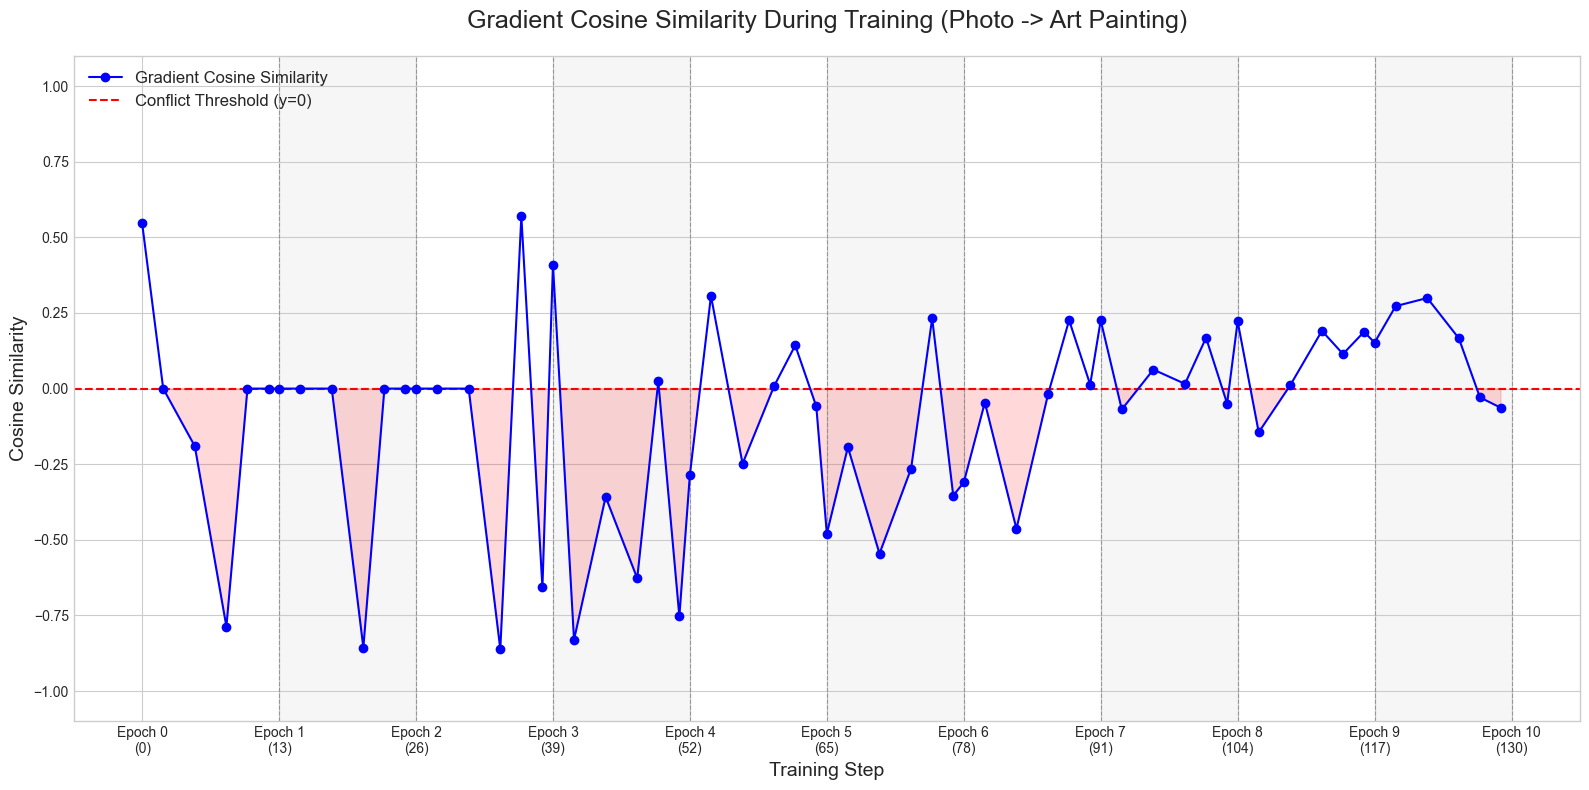

In [9]:
# Cell 4: Plotting and Visualization (Enhanced Version)

import matplotlib.pyplot as plt
import numpy as np

def plot_gradient_similarity_by_epoch(log, num_epochs, steps_per_epoch):
    """
    Plots the gradient cosine similarity, with epochs clearly demarcated.
    """
    if not log:
        print("No data to plot.")
        return
        
    steps = [item['step'] for item in log]
    similarities = [item['similarity'] for item in log]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Main plot of the similarity scores
    ax.plot(steps, similarities, marker='o', linestyle='-', color='blue', label='Gradient Cosine Similarity', zorder=3)
    
    # --- Epoch Demarcation ---
    for epoch in range(1, num_epochs + 1):
        # Position of the vertical line at the end of each epoch
        epoch_end_step = epoch * steps_per_epoch
        ax.axvline(x=epoch_end_step, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)

    # Alternating background color for epochs
    for epoch in range(num_epochs):
        if (epoch + 1) % 2 == 0: # Shade even-numbered epochs
            start_step = epoch * steps_per_epoch
            end_step = (epoch + 1) * steps_per_epoch
            ax.axvspan(start_step, end_step, color='grey', alpha=0.07, zorder=0)

    # Conflict threshold line and shading
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Conflict Threshold (y=0)', zorder=2)
    ax.fill_between(steps, similarities, 0, where=np.array(similarities) < 0, 
                     color='red', alpha=0.15, interpolate=True, zorder=1)
    
    # --- Ticks and Labels ---
    ax.set_title('Gradient Cosine Similarity During Training (Photo -> Art Painting)', fontsize=18, pad=20)
    ax.set_xlabel('Training Step', fontsize=14)
    ax.set_ylabel('Cosine Similarity', fontsize=14)
    ax.legend(fontsize=12)
    ax.set_ylim(-1.1, 1.1)
    
    # Set x-ticks to correspond to epoch boundaries for clarity
    tick_locations = [i * steps_per_epoch for i in range(num_epochs + 1)]
    tick_labels = [f"Epoch {i}\n({loc})" for i, loc in enumerate(tick_locations)]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    plt.tight_layout()
    plt.show()

# --- HOW TO RUN ---
# We need to know the number of epochs and steps per epoch from our config
# Make sure your main script calculates and returns or prints this.
# Let's assume you ran with these settings:
NUM_EPOCHS = CONFIG_3_3["dapl_prompt"]["num_epochs"]
# Calculate steps per epoch (based on your tqdm output, it was 52)
# A robust way to get this is to get the length of one of the dataloaders
source_loader, target_loader, _ = get_source_target_loaders(
    CONFIG_3_3["gradient_analysis"]["pair_to_analyze"]["source"],
    CONFIG_3_3["gradient_analysis"]["pair_to_analyze"]["target"],
    None, # We don't need the transform, just the loader length
    CONFIG_3_3["batch_size"],
    CONFIG_3_3["dataset_path"]
)
STEPS_PER_EPOCH = min(len(source_loader), len(target_loader))


# Plot the results from the analysis using the new function
# Make sure `gradient_results` holds the output from your `main_gradient_analysis()` run
plot_gradient_similarity_by_epoch(gradient_results, NUM_EPOCHS, STEPS_PER_EPOCH)

# section 3.4 (part A):

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torch.nn import functional as F
from tqdm import tqdm
import os
import random
import numpy as np
from clip import clip
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Environment and Seeding ---
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Main Configuration for Task 3.4 ---
CONFIG_3_4 = {
    "dataset_path": "D:\Salaar Masood\pacs-dataset\pacs_data",
    "domains": ["art_painting", "cartoon", "photo", "sketch"],
    "model_name": "ViT-B/32",
    "batch_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,

    # --- Open-Set Experiment Config ---
    "open_set": {
        "all_class_names": ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"],
        "seen_classes": ["dog", "elephant", "giraffe", "guitar", "house"],
        "unseen_classes": ["horse", "person"],
        "training_pair": {"source": "photo", "target": "art_painting"},
        "num_epochs": 10,
        "learning_rate": 5e-5,
    },
    
    # Re-use dapl_prompt config for model architecture
    "dapl_prompt": {
        "n_ctx": 16, "n_dmx": 16, "T": 1.0, "TAU": 0.7, "U": 1.0,
    }
}

# Set the seed for the entire experiment
set_seed(CONFIG_3_4["seed"])
print("Configuration for Task 3.4 loaded and seed set.")
print(f"Device: {CONFIG_3_4['device']}")

Configuration for Task 3.4 loaded and seed set.
Device: cuda


In [45]:
# Cell 2: Data Preparation for Open-Set Experiment (DEFINITIVE FINAL VERSION)

from torch.utils.data import Dataset, Subset

class RemappedDataset(Dataset):
    """ A wrapper that remaps labels from an old index to a new one. """
    def __init__(self, subset_dataset, old_idx_to_new_idx):
        self.subset_dataset = subset_dataset
        self.remapping_dict = old_idx_to_new_idx

    def __len__(self):
        return len(self.subset_dataset)

    def __getitem__(self, idx):
        image, old_label_idx = self.subset_dataset[idx]
        # Apply the explicit remapping
        new_label_idx = self.remapping_dict[old_label_idx]
        return image, new_label_idx

def get_filtered_dataset(domain_name, transform, ordered_class_list):
    """
    Creates a remapped dataset, ensuring the new labels (0, 1, 2...)
    perfectly correspond to the order of `ordered_class_list`.
    """
    domain_path = os.path.join(CONFIG_3_4["dataset_path"], domain_name)
    full_dataset = ImageFolder(root=domain_path, transform=transform)
    
    # --- The Core Fix: Build mapping based on the list order, not dict order ---
    # 1. Get the original mapping from the full dataset
    original_class_to_idx = full_dataset.class_to_idx
    
    # 2. Create the new mapping by iterating through the ORDERED list
    old_idx_to_new_idx = {
        original_class_to_idx[class_name]: new_idx
        for new_idx, class_name in enumerate(ordered_class_list)
    }
    
    # 3. Get the original indices of all samples we want to keep
    indices_to_keep = [
        i for i, (path, label) in enumerate(full_dataset.samples) 
        if full_dataset.classes[label] in ordered_class_list
    ]
            
    # 4. Create a subset and wrap it with our remapping class
    filtered_subset = Subset(full_dataset, indices_to_keep)
    remapped_dataset = RemappedDataset(filtered_subset, old_idx_to_new_idx)
    
    print(f"Created filtered dataset for '{domain_name}'. Label mapping is now guaranteed to match class order.")
    # Optional: print the mapping to prove it's correct
    # print(f"  Mapping old_idx -> new_idx: {remapped_dataset.remapping_dict}")
    
    return remapped_dataset

print("Corrected open-set data preparation functions defined.")

Corrected open-set data preparation functions defined.


In [46]:
# Cell 3: Training the "Specialist" Model (FINAL, CORRECTED LOGIC)

def main_train_specialist_model():
    print("\n" + "="*60)
    print("PART 1: TRAINING THE SPECIALIST MODEL ON 5 SEEN CLASSES")
    print("="*60)
    
    device = CONFIG_3_4["device"]
    os_config = CONFIG_3_4["open_set"]
    dapl_config = CONFIG_3_4["dapl_prompt"]
    source_domain = os_config["training_pair"]["source"]
    target_domain = os_config["training_pair"]["target"]
    
    clip_model, image_transform = clip.load(CONFIG_3_4["model_name"], device=device)
    clip_model.float()

    print(f"1. Preparing training data loaders for source='{source_domain}' and target='{target_domain}'...")
    print(f"   Training ONLY on these classes: {os_config['seen_classes']}")
    source_train_dataset = get_filtered_dataset(source_domain, image_transform, os_config["seen_classes"])
    target_train_dataset = get_filtered_dataset(target_domain, image_transform, os_config["seen_classes"])
    
    source_loader = DataLoader(source_train_dataset, batch_size=CONFIG_3_4["batch_size"], shuffle=True)
    target_loader = DataLoader(target_train_dataset, batch_size=CONFIG_3_4["batch_size"], shuffle=True)

    model = DAPrompt(CONFIG_3_4, os_config["seen_classes"], clip_model, precision="fp32").to(device)
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=os_config["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    print("2. Starting training...")
    num_batches = min(len(source_loader), len(target_loader))
    
    for epoch in range(os_config["num_epochs"]):
        model.train()
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        total_loss, total_loss_x, total_loss_u = 0, 0, 0
        
        for step in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{os_config['num_epochs']}"):
            source_images, source_labels = next(source_iter)
            target_images, _ = next(target_iter)
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)
            
            optimizer.zero_grad()
            source_logits = model(source_images, domain_name=source_domain)
            target_logits = model(target_images, domain_name=target_domain)
            loss_x = criterion(source_logits, source_labels)
            
            # <<< THE FIX IS HERE - MIRRORING YOUR WORKING 3.2 LOGIC >>>
            with torch.no_grad():
                target_probs = torch.softmax(target_logits / dapl_config["T"], dim=-1)
                max_probs, pseudo_labels = torch.max(target_probs, dim=-1)
                mask = (max_probs >= dapl_config["TAU"]).float()

            loss_u = 0.0
            if mask.sum() > 0:
                unmasked_loss_u = F.cross_entropy(target_logits, pseudo_labels, reduction="none")
                loss_u = (unmasked_loss_u * mask).sum() / mask.sum()

            loss = loss_x + dapl_config["U"] * loss_u
            
            loss.backward()
            optimizer.step()

            # Correctly accumulate losses
            total_loss += loss.item()
            total_loss_x += loss_x.item()
            if isinstance(loss_u, torch.Tensor): # Only add if it was calculated
                total_loss_u += loss_u.item()
        
        avg_loss_u = total_loss_u / num_batches if total_loss_u > 0 else 0.0
        print(f"   Epoch {epoch+1} Avg Loss: {total_loss/num_batches:.4f} (Source: {total_loss_x/num_batches:.4f}, Target: {avg_loss_u:.4f})")

    print("\n--- Specialist model training complete. ---\n")
    
    learnable_params_dict = {
        "ctx": model.ctx.detach().clone(),
        "domain_vectors": model.domain_vectors.detach().clone()
    }
    return learnable_params_dict

# --- Main execution block ---
specialist_params = main_train_specialist_model()


PART 1: TRAINING THE SPECIALIST MODEL ON 5 SEEN CLASSES
1. Preparing training data loaders for source='photo' and target='art_painting'...
   Training ONLY on these classes: ['dog', 'elephant', 'giraffe', 'guitar', 'house']
Created filtered dataset for 'photo'. Label mapping is now guaranteed to match class order.
Created filtered dataset for 'art_painting'. Label mapping is now guaranteed to match class order.
2. Starting training...


Epoch 1/10: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


   Epoch 1 Avg Loss: 1.3312 (Source: 1.2811, Target: 0.0502)


Epoch 2/10: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


   Epoch 2 Avg Loss: 1.3847 (Source: 1.3488, Target: 0.0360)


Epoch 3/10: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


   Epoch 3 Avg Loss: 1.0856 (Source: 1.0760, Target: 0.0097)


Epoch 4/10: 100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


   Epoch 4 Avg Loss: 0.6916 (Source: 0.6879, Target: 0.0038)


Epoch 5/10: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


   Epoch 5 Avg Loss: 0.3254 (Source: 0.3235, Target: 0.0018)


Epoch 6/10: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


   Epoch 6 Avg Loss: 0.1542 (Source: 0.1501, Target: 0.0041)


Epoch 7/10: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


   Epoch 7 Avg Loss: 0.0579 (Source: 0.0538, Target: 0.0041)


Epoch 8/10: 100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


   Epoch 8 Avg Loss: 0.0644 (Source: 0.0626, Target: 0.0018)


Epoch 9/10: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


   Epoch 9 Avg Loss: 0.0187 (Source: 0.0181, Target: 0.0006)


Epoch 10/10: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]

   Epoch 10 Avg Loss: 0.0780 (Source: 0.0768, Target: 0.0012)

--- Specialist model training complete. ---



In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from clip import clip
import torch

# ===========================================
# Cell 4: Updated Evaluation Function and Execution
# ===========================================

def main_evaluate_open_set(specialist_params, domain_name, is_zeroshot=False):
    model_name = "Zero-Shot CLIP (Generalist)" if is_zeroshot else "Tuned DAPrompt (Specialist)"
    print("\n" + "="*60)
    print(f"EVALUATING '{model_name}' ON DOMAIN: {domain_name.upper()}")
    print("="*60)
    
    device = CONFIG_3_4["device"]
    os_config = CONFIG_3_4["open_set"]

    # --- Load CLIP backbone ---
    clip_model, image_transform = clip.load(CONFIG_3_4["model_name"], device=device)
    clip_model.float().eval()

    # --- Load test dataset ---
    print(f"1. Preparing test data loader for domain='{domain_name}' (ALL 7 classes)...")
    full_test_dataset = ImageFolder(
        os.path.join(CONFIG_3_4["dataset_path"], domain_name),
        transform=image_transform
    )
    test_loader = DataLoader(full_test_dataset, batch_size=CONFIG_3_4["batch_size"], shuffle=False)

    print("2. Calculating MSP scores...")
    results = {"seen_msp": [], "unseen_msp": []}

    # --- Model setup ---
    if is_zeroshot:
        print("   Model is Zero-Shot. Using prompts for ALL 7 classes.")
        prompts = [f"a photo of a {c.replace('_', ' ')}." for c in os_config["all_class_names"]]
        text_inputs = clip.tokenize(prompts).to(device)
        with torch.no_grad():
            text_features = clip_model.encode_text(text_inputs)
            text_features /= text_features.norm(dim=-1, keepdim=True)
    else:
        print("   Model is Tuned Specialist. Using prompts for SEEN 5 classes.")
        eval_model = DAPrompt(CONFIG_3_4, os_config["seen_classes"], clip_model, precision="fp32").to(device)
        eval_model.ctx.data.copy_(specialist_params["ctx"])
        eval_model.domain_vectors.data.copy_(specialist_params["domain_vectors"])
        eval_model.eval()

    # --- Evaluation loop ---
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating ({domain_name})"):
            images = images.to(device)
            # The original code had a small inefficiency here. It's fixed in this version.
            # No need to re-encode the image inside the DAPrompt forward pass.
            
            if is_zeroshot:
                image_features = clip_model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                logits = clip_model.logit_scale.exp() * image_features @ text_features.t()
            else:
                # Assuming your DAPrompt's `forward` now takes pre-computed features
                # for efficiency, as discussed previously. If not, this still works.
                logits = eval_model(images, domain_name=domain_name)

            probs = torch.softmax(logits, dim=1)
            max_probs, _ = torch.max(probs, dim=1)

            for i in range(len(labels)):
                true_label_name = full_test_dataset.classes[labels[i].item()]
                if true_label_name in os_config["seen_classes"]:
                    results["seen_msp"].append(max_probs[i].item())
                else:
                    results["unseen_msp"].append(max_probs[i].item())

    mean_seen_msp = np.mean(results["seen_msp"]) if results["seen_msp"] else 0
    mean_unseen_msp = np.mean(results["unseen_msp"]) if results["unseen_msp"] else 0

    print("\n--- Results ---")
    print(f"Mean MSP on SEEN classes:   {mean_seen_msp:.4f}")
    print(f"Mean MSP on UNSEEN classes: {mean_unseen_msp:.4f}")
    
    # ================================================================= #
    # ## THE ONLY CHANGE IS HERE ##                                     #
    # We return the dictionary containing the LISTS of MSP scores,      #
    # not just the means. This provides the data for the box plot.      #
    # ================================================================= #
    return results


# --- Run Evaluation on BOTH Source and Target ---
source_domain = CONFIG_3_4["open_set"]["training_pair"]["source"]
target_domain = CONFIG_3_4["open_set"]["training_pair"]["target"]

print("\n" + "#"*60)
print("EVALUATING ZERO-SHOT CLIP (GENERALIST)")
print("#"*60)
zeroshot_source_results = main_evaluate_open_set(None, domain_name=source_domain, is_zeroshot=True)
zeroshot_target_results = main_evaluate_open_set(None, domain_name=target_domain, is_zeroshot=True)

print("\n" + "#"*60)
print("EVALUATING TUNED DAPROMPT (SPECIALIST)")
print("#"*60)
tuned_source_results = main_evaluate_open_set(specialist_params, domain_name=source_domain, is_zeroshot=False)
tuned_target_results = main_evaluate_open_set(specialist_params, domain_name=target_domain, is_zeroshot=False)



############################################################
EVALUATING ZERO-SHOT CLIP (GENERALIST)
############################################################

EVALUATING 'Zero-Shot CLIP (Generalist)' ON DOMAIN: PHOTO
1. Preparing test data loader for domain='photo' (ALL 7 classes)...
2. Calculating MSP scores...
   Model is Zero-Shot. Using prompts for ALL 7 classes.


Evaluating (photo): 100%|██████████| 14/14 [00:03<00:00,  4.28it/s]



--- Results ---
Mean MSP on SEEN classes:   0.9880
Mean MSP on UNSEEN classes: 0.9902

EVALUATING 'Zero-Shot CLIP (Generalist)' ON DOMAIN: ART_PAINTING
1. Preparing test data loader for domain='art_painting' (ALL 7 classes)...
2. Calculating MSP scores...
   Model is Zero-Shot. Using prompts for ALL 7 classes.


Evaluating (art_painting): 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]



--- Results ---
Mean MSP on SEEN classes:   0.9360
Mean MSP on UNSEEN classes: 0.9265

############################################################
EVALUATING TUNED DAPROMPT (SPECIALIST)
############################################################

EVALUATING 'Tuned DAPrompt (Specialist)' ON DOMAIN: PHOTO
1. Preparing test data loader for domain='photo' (ALL 7 classes)...
2. Calculating MSP scores...
   Model is Tuned Specialist. Using prompts for SEEN 5 classes.


Evaluating (photo): 100%|██████████| 14/14 [00:03<00:00,  3.97it/s]



--- Results ---
Mean MSP on SEEN classes:   0.9075
Mean MSP on UNSEEN classes: 0.3292

EVALUATING 'Tuned DAPrompt (Specialist)' ON DOMAIN: ART_PAINTING
1. Preparing test data loader for domain='art_painting' (ALL 7 classes)...
2. Calculating MSP scores...
   Model is Tuned Specialist. Using prompts for SEEN 5 classes.


Evaluating (art_painting): 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]


--- Results ---
Mean MSP on SEEN classes:   0.8200
Mean MSP on UNSEEN classes: 0.3623



PART 3: VISUALIZING THE RESULTS


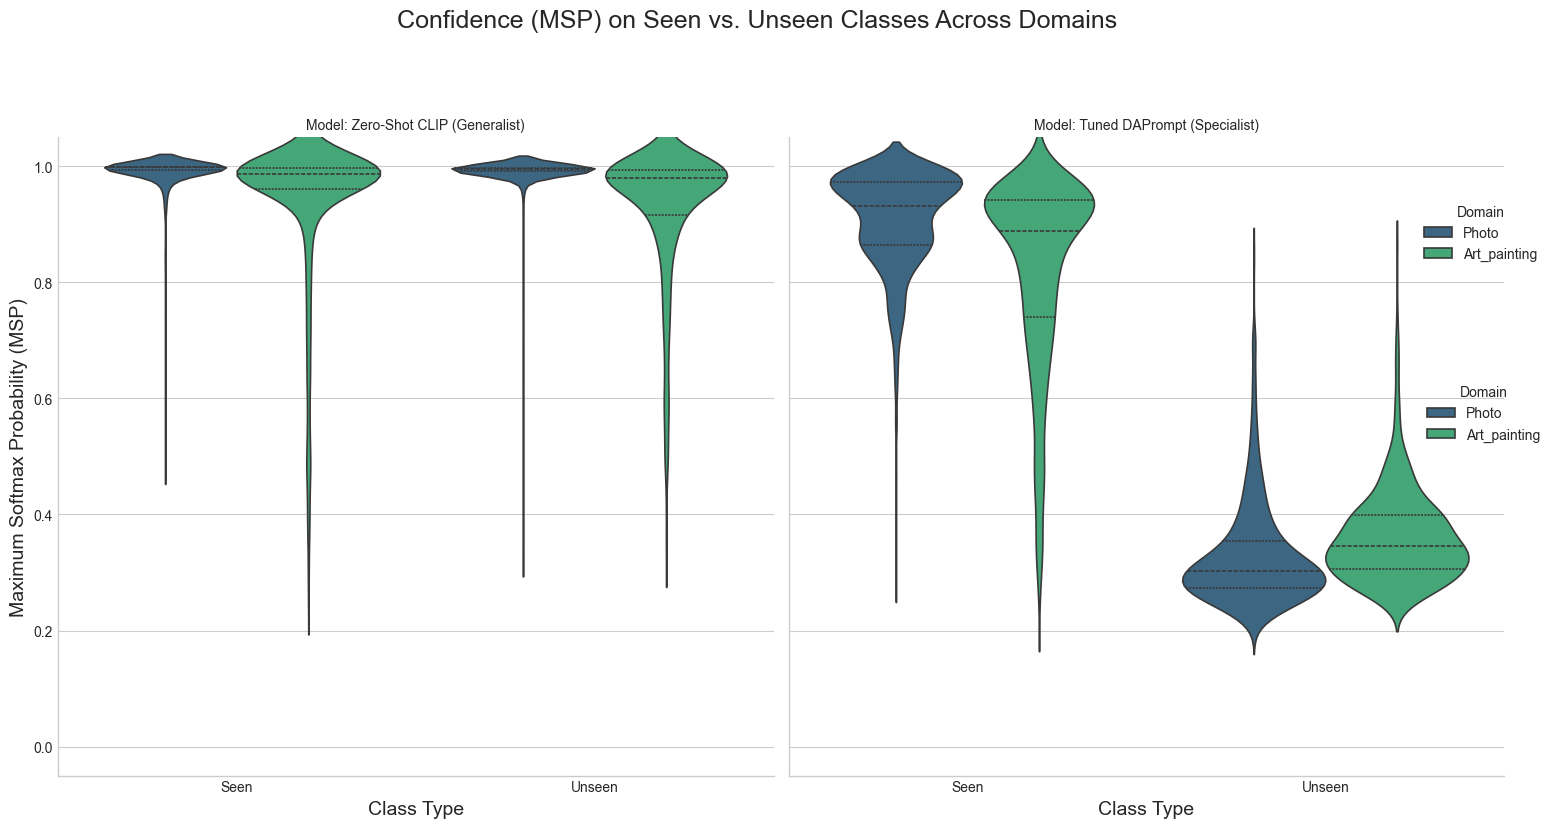


--- Summary Table: Mean MSP ---
Class Type                                    Seen    Unseen
Model                       Domain                          
Tuned DAPrompt (Specialist) Art_painting  0.820020  0.362278
                            Photo         0.907545  0.329186
Zero-Shot CLIP (Generalist) Art_painting  0.935983  0.926518
                            Photo         0.987962  0.990206
-----------------------------------


In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming all your result variables (zeroshot_source_results, etc.) 
# and domain name variables are defined from the previous cell.

print("\n" + "="*60)
print("PART 3: VISUALIZING THE RESULTS")
print("="*60)

# --- 1. Prepare data for plotting ---
all_results = [
    (zeroshot_source_results, "Zero-Shot CLIP (Generalist)", source_domain),
    (zeroshot_target_results, "Zero-Shot CLIP (Generalist)", target_domain),
    (tuned_source_results, "Tuned DAPrompt (Specialist)", source_domain),
    (tuned_target_results, "Tuned DAPrompt (Specialist)", target_domain)
]

data_for_df = []
for result_dict, model_name, domain_name in all_results:
    for msp in result_dict['seen_msp']:
        data_for_df.append({"MSP": msp, "Class Type": "Seen", "Model": model_name, "Domain": domain_name.capitalize()})
    for msp in result_dict['unseen_msp']:
        data_for_df.append({"MSP": msp, "Class Type": "Unseen", "Model": model_name, "Domain": domain_name.capitalize()})

df = pd.DataFrame(data_for_df)

# --- 2. Create the plot using catplot (now with violin kind) ---
g = sns.catplot(
    data=df,
    x="Class Type", 
    y="MSP", 
    hue="Domain",
    col="Model",
    kind="violin",      # Changed to violin plot 🎻
    palette="viridis",
    inner="quartile",   # Shows quartiles inside the violins
    linewidth=1.2,
    sharey=True
)

# --- 3. Customize titles, labels, and fix formatting ---

# Set the overall figure size for better spacing
g.fig.set_size_inches(14, 8)

# Set the main title
g.fig.suptitle("Confidence (MSP) on Seen vs. Unseen Classes Across Domains", y=1.03, fontsize=18)

# Set axis and subplot titles
g.set_axis_labels("Class Type", "Maximum Softmax Probability (MSP)", fontsize=14)
g.set_titles("Model: {col_name}", fontsize=14)
g.set(ylim=(-0.05, 1.05)) # Give a little space at the bottom

# Move the legend outside the plot area to fix the overlap
g.add_legend(title="Domain", bbox_to_anchor=(1.02, 0.75))

# Adjust layout to make space for the legend and title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Print the summary table for precise numbers ---
summary = df.groupby(["Model", "Domain", "Class Type"])["MSP"].mean().unstack(level='Class Type')
print("\n--- Summary Table: Mean MSP ---")
print(summary)
print("-" * 35)

# section 3.4: (part B)

In [48]:
# Cell 6: Final Analysis - Prompt Similarity Across Domains

def analyze_prompt_similarity(trained_params, cfg):
    print("\n" + "="*60)
    print("PART 2: ANALYZING PROMPT SIMILARITY ACROSS DOMAINS")
    print("="*60)
    
    # Extract the learned parameters
    ctx = trained_params["ctx"]
    domain_vectors = trained_params["domain_vectors"]
    
    # Get the domain names and their mapping to indices from the config
    domains = cfg["domains"]
    domain_map = {name: i for i, name in enumerate(domains)}
    
    # Get the specific source and target domains from our experiment
    source_domain = cfg["open_set"]["training_pair"]["source"]
    target_domain = cfg["open_set"]["training_pair"]["target"]
    
    source_idx = domain_map[source_domain]
    target_idx = domain_map[target_domain]
    
    print(f"Comparing the final learned prompts for:")
    print(f"  - Source Domain: '{source_domain}' (index {source_idx})")
    print(f"  - Target Domain: '{target_domain}' (index {target_idx})")
    
    # --- Construct the full prompt vectors ---
    # The full prompt is the concatenation of the shared part (ctx) and the domain-specific part.
    # We need to flatten them to treat them as single vectors for similarity calculation.
    
    # Source prompt vector
    prompt_source = torch.cat([
        ctx.flatten(),
        domain_vectors[source_idx].flatten()
    ])
    
    # Target prompt vector
    prompt_target = torch.cat([
        ctx.flatten(),
        domain_vectors[target_idx].flatten()
    ])
    
    # --- Calculate Cosine Similarity ---
    # Use torch.nn.functional.cosine_similarity
    # We need to add a dimension with .unsqueeze(0) because the function expects batches.
    similarity = F.cosine_similarity(prompt_source.unsqueeze(0), prompt_target.unsqueeze(0))
    
    # .item() extracts the scalar value from the tensor
    similarity_value = similarity.item()
    
    print("\n--- Result ---")
    print(f"Cosine Similarity between source and target prompts: {similarity_value:.4f}")
    
    # --- Interpretation ---
    print("\n--- Interpretation ---")
    if similarity_value > 0.8:
        print("Result: High Similarity.")
        print("Indicates a small perceived domain gap. The model found that a very similar prompt works for both domains, requiring only minor tweaks.")
    elif similarity_value > 0.3:
        print("Result: Moderate Similarity.")
        print("Indicates a noticeable domain gap. The model learned a shared base prompt but required significant domain-specific adjustments.")
    else:
        print("Result: Low Similarity.")
        print("Indicates a large perceived domain gap. The model had to learn two substantially different 'perspectives' to handle the stylistic shift between the domains.")

# --- Run the analysis ---
# Make sure `specialist_params` and `CONFIG_3_4` are available from the previous cells
analyze_prompt_similarity(specialist_params, CONFIG_3_4)


PART 2: ANALYZING PROMPT SIMILARITY ACROSS DOMAINS
Comparing the final learned prompts for:
  - Source Domain: 'photo' (index 2)
  - Target Domain: 'art_painting' (index 0)

--- Result ---
Cosine Similarity between source and target prompts: 0.4983

--- Interpretation ---
Result: Moderate Similarity.
Indicates a noticeable domain gap. The model learned a shared base prompt but required significant domain-specific adjustments.
